# [Data Preprocessing](http://colab.research.google.com/github/boringPpl/presidential_debates_comments_clustering/blob/main/preprocess_data.ipynb)

## 1. Setup

### 1.1 Hardware

First, check that the runtime in Google Colab is set to GPU. If it is not, go to **Runtime > Change runtime type** and change the **Hardware Accelerator** to **GPU**.

In [3]:
!nvidia-smi

Mon Jun 14 12:39:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The following shows the CPU details for the Google Colab instance

In [4]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

The memory available for the instance is listed as follows

In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        549M         10G        1.1M        2.1G         11G
Swap:            0B          0B          0B


### 1.2 Install Dependencies

In [6]:
!git clone https://github.com/boringPpl/presidential_debates_comments_clustering.git
%cd presidential_debates_comments_clustering
!pip install -qr requirements.txt

Cloning into 'presidential_debates_comments_clustering'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 187 (delta 5), reused 15 (delta 3), pack-reused 167
Receiving objects: 100% (187/187), 93.92 MiB | 18.29 MiB/s, done.
Resolving deltas: 100% (81/81), done.
/content/presidential_debates_comments_clustering
     |████████████████████████████████| 133kB 7.5MB/s 
     |████████████████████████████████| 6.4MB 20.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 890kB 44.0MB/s 
     |████████████████████████████████| 1.2MB 49.2MB/s 
     |████████████████████████████████| 3.0MB 52.9MB/s 
     |████████████████████████████████| 901kB 46.0MB/s 


In [7]:
import numpy as np
import pandas as pd
import emoji

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

## 2. Exploratory Data Analysis

### 2.1 Load data into Pandas

In [8]:
def load_comments(video_id):
    filename = f'data/{video_id}_csv_final.feather'
    df = pd.read_feather(filename)
    return df

In [9]:
# This is the dataset for the first presidential debate.
df1 = load_comments('wW1lY5jFNcQ')
comments1 = df1['Comments']
df1['Updated At'] = pd.to_datetime(df1['Updated At'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

### 2.2 Exploratory data analysis

In [10]:
print(f'The shape of the dataframe is: {df1.shape}')
print(f"The time range for the data is: {df1['Updated At'].min():%Y-%m-%d %H%Mh} to {df1['Updated At'].max():%Y-%m-%d %H%Mh}")
df1.head()

The shape of the dataframe is: (53271, 6)
The time range for the data is: 2020-09-30 0245h to 2021-03-28 1717h


,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating
0,Trump's America: *7M cases*\nBiden: 200K peopl...,UgzOHAjMxYA4Q1NXivR4AaABAg,0,0,2021-03-28 17:17:10,none
1,Wow Joes laugh makes me cringe 😬,Ugy1AdZUVDPjO-YzszB4AaABAg,0,0,2021-03-28 09:49:51,none
2,"Dang hate to say it, Trump seems sharp compar...",UgwxiTXgqmNvg0nQZ554AaABAg,1,0,2021-03-28 09:48:46,none
3,"HEY BIDEN, I HAVE A FEELING YOU WERE IN ON THE...",UgyjoIPRCH0X57xnKa94AaABAg,0,0,2021-03-27 15:16:51,none
4,FAKE BRIDEN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,UgxXf4RANq3Per7_lKR4AaABAg,0,0,2021-03-27 15:15:17,none


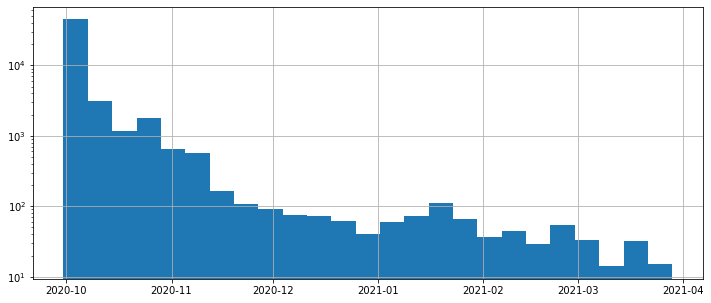

In [11]:
ax = df1['Updated At'].hist(bins=25, figsize=(12, 5))
ax.set_yscale('log')

In [12]:
import emoji
print(emoji.demojize('trending 😉	'))

trending :winking_face:	


In [13]:
df_corpus = df1

In [14]:
df_corpus.rename(columns={'Comments': 'comment_text'}, inplace=True)

In [15]:
# De-emojize
df_corpus['comments_cleaned'] = df_corpus['comment_text'].apply(emoji.demojize)

# Replace the colons, and \n with a space
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[\n:]', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace(r'\\n', ' ', regex=True)

In [16]:
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.lower()

In [17]:
df_corpus.drop_duplicates(subset=['comments_cleaned'], inplace = True)
df_corpus.shape

(50889, 7)

In [18]:
# remove special characters
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[^a-zA-Z0-9]', ' ')

# remove white spaces
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('\s+', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.strip()

In [31]:
# Save metadata in .tsv and .parquet formats
df_corpus['comments_cleaned'].to_csv('meta.tsv', columns=['comments_cleaned'], index= False, header= False)
df_corpus[['comments_cleaned']].to_parquet('meta.parquet', index=False)

The longest comment has 16120 characters

In [32]:
df_corpus['comments_cleaned'].apply(len).sort_values(ascending=False).head(20)

17433    16120
34534    10709
33397     9944
2455      9649
15230     9594
41574     9539
16652     9261
29426     8957
5256      8910
16754     8711
2614      8534
22371     8399
37653     7883
47314     7336
25375     7324
42454     7260
19705     7145
27632     7129
16743     6957
26948     6955
Name: comments_cleaned, dtype: int64

## Sentence Bert Embeddings

In [33]:
corpus_embeddings = embedder.encode(df_corpus["comments_cleaned"].values.tolist())

In [34]:
corpus_embeddings = np.array(corpus_embeddings)
corpus_embeddings.shape

(50889, 768)

In [35]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, corpus_embeddings, 90)

## Google Universal Encoder

In [36]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [37]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the emtbedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.034585606306791306, -0.01799013651907444, 0.0019805855117738247, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833391845226288, -0.08185010403394699, 0.06890939176082611, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the emtbedding will be.
Embedding size: 512
Embedding: [-0.018883436918258667, -0.0031109144911170006, -0.033673398196697235, ...]



## Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [38]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [39]:
messages0 = df_corpus["comments_cleaned"].values.tolist()

In [40]:
df_corpus["comments_cleaned"].apply(len).max()

16120

In [41]:
# embeddings_long = embed([df_corpus['comments_cleaned'].loc[617593]])

In [42]:
# [USComments.csv] Take only the first 2200 characters of each comment. Crashes at 2300+
# [Presidential Debate 1] < 2200. Trying 2000 [Nope]. Trying 1800 [Nope].
# Trying 1000 [Nope]. Trying 500 [Nope]. Trying 200.
max_chars = 200
messages = df_corpus["comments_cleaned"].apply(
    lambda x: x[:max_chars]
).values.tolist()

In [43]:
print('Embeddings can only be done with about 500 rows at a time')
n_chunks = len(messages) // 500
message_list = np.array_split(np.array(messages), n_chunks)
print(f'The {len(messages)} messages will be divided into {n_chunks} chunks of approximately 500 rows per chunk')

Embeddings can only be done with about 500 rows at a time
The 50889 messages will be divided into 101 chunks of approximately 500 rows per chunk


In [44]:
for i, message in enumerate(message_list):
    if i == 0:
        embeddings = embed(message).numpy()
    else:
        embedding = embed(message).numpy()
        embeddings = np.vstack((embeddings, embedding))

In [45]:
print(f'The embeddings numpy array has shape: {embeddings.shape}')

The embeddings numpy array has shape: (50889, 512)


Saving 47k rows of data will take a long time (the final size is 634MB)

In [56]:
df_embeddings = pd.DataFrame(embeddings)
df_embeddings.columns = [ str(x) for x in df_embeddings.columns ]
df_embeddings.to_parquet('vecs0.parquet', index=False)
np.savetxt('vecs0.tsv', embeddings , delimiter="\t")

In [59]:
# Check the final size of the file
!ls -lh vecs0*

-rw-r--r-- 1 root root 149M Jun 14 12:56 vecs0.parquet
-rw-r--r-- 1 root root 634M Jun 14 12:57 vecs0.tsv


In [61]:
# Find the maximum length of the messages
pd.Series(messages).apply(len).max()

200

### PCA reduction

The size of `vecs.tsv` can be reduced further.
Using PCA, the number of dimensions of each embedding is reduced from 512 to 50.

In [62]:
from sklearn.decomposition import PCA

In [63]:
#scale the data 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rescaled = scaler.fit_transform(embeddings)

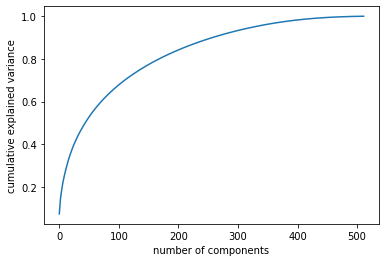

In [64]:
pca = PCA().fit(rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [65]:
# need around 200 components to describe 100% of variance
pca = PCA(n_components = 50)
reduced_embeds = pca.fit_transform(rescaled)
print("Original shape:   ", rescaled.shape)
print("Transformed shape:", reduced_embeds.shape)

Original shape:    (50889, 512)
Transformed shape: (50889, 50)


In [66]:
pca = PCA(n_components = 50)
reduced_embeds = pca.fit_transform(rescaled)
reduced_embeds.shape

(50889, 50)

In [92]:
# Save embeddings in .parquet and .tsv
df_reduced = pd.DataFrame(reduced_embeds)
df_reduced.columns = [ str(x) for x in df_reduced.columns ]
df_reduced.to_parquet('vecs.parquet', index=False)
np.savetxt('vecs.tsv', reduced_embeds , delimiter="\t")
np.savetxt('vecs_5k.tsv', reduced_embeds[:5000] , delimiter="\t")

After dimension reduction using PCA, the file size has been reduced from 634 MB to 62 MB (or 149 MB to 15 MB for the .parquet format)

In [93]:
!ls -lh vecs*

-rw-r--r-- 1 root root 149M Jun 14 12:56 vecs0.parquet
-rw-r--r-- 1 root root 634M Jun 14 12:57 vecs0.tsv
-rw-r--r-- 1 root root 6.1M Jun 14 13:10 vecs_5k.tsv
-rw-r--r-- 1 root root  15M Jun 14 13:10 vecs.parquet
-rw-r--r-- 1 root root  62M Jun 14 13:10 vecs.tsv


## Run HDBScan to find the clusters

Note: the next code block takes a long time

In [69]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(reduced_embeds)
clusterer.labels_

array([ -1, 104,  -1, ...,  -1, 332,  -1])

In [70]:
clusterer.labels_.max()

365

In [71]:
df_corpus['hdb_labels'] = clusterer.labels_

In [82]:
# df_meta_lab = df_corpus[['comments_cleaned','hdb_labels']].copy()
df_meta_lab = df_corpus[['comment_text','hdb_labels']].copy()

In [83]:
df_meta_lab['comment_text'] = df_meta_lab['comment_text'].str.replace('\n', ' ')

In [94]:
df_meta_lab.to_csv('meta_lab.tsv', index=False, header=True, sep='\t')
df_meta_lab.head(5000).to_csv('meta_lab_5k.tsv', index=False, header=True, sep='\t')
df_meta_lab.to_parquet('meta_lab.parquet', index=False)

In [95]:
!head -7 meta.tsv

trump s america 7m cases biden 200k people have already died under his rule biden s america 30m cases 500k deaths biden well sometimes we fall and rise again
wow joes laugh makes me cringe grimacing face
dang hate to say it trump seems sharp compared to biden recently
hey biden i have a feeling you were in on the scandal in new york to make trump look bad make more deaths on his watch
fake briden look what he is doing to america
why is there not a panel of questionnaires america united states is to only listen view 1 persons questions really
i just watched bidens first news press conference and then thought i d stop by here again since it s so hilarious


In [96]:
!head -8 meta_lab.tsv

comment_text	hdb_labels
Trump's America: *7M cases* Biden: 200K people have already died under his rule!  Biden's America: *30M CASES+500K deaths* Biden: Well sometimes we fall and rise again	-1
Wow Joes laugh makes me cringe 😬	104
Dang hate to say it,  Trump seems sharp compared to Biden recently	-1
HEY BIDEN, I HAVE A FEELING YOU WERE IN ON THE SCANDAL IN NEW YORK  TO MAKE TRUMP LOOK BAD, MAKE MORE DEATHS ON HIS WATCH!!!	-1
FAKE BRIDEN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! LOOK WHAT HE IS DOING TO AMERICA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!	-1
Why is there NOT a panel of questionnaires? America 🇺🇸 is to only listen & view 1 persons questions?!? Really???	-1
I just watched bidens first news press conference and then thought I'd stop by here again since it's so hilarious	-1


In [97]:
!ls -lh *.tsv

-rw-r--r-- 1 root root 644K Jun 14 13:11 meta_lab_5k.tsv
-rw-r--r-- 1 root root 6.1M Jun 14 13:11 meta_lab.tsv
-rw-r--r-- 1 root root 5.9M Jun 14 12:47 meta.tsv
-rw-r--r-- 1 root root 634M Jun 14 12:57 vecs0.tsv
-rw-r--r-- 1 root root 6.1M Jun 14 13:10 vecs_5k.tsv
-rw-r--r-- 1 root root  62M Jun 14 13:10 vecs.tsv


In [98]:
!ls -lh *.parquet

-rw-r--r-- 1 root root 4.0M Jun 14 13:11 meta_lab.parquet
-rw-r--r-- 1 root root 3.6M Jun 14 12:47 meta.parquet
-rw-r--r-- 1 root root 149M Jun 14 12:56 vecs0.parquet
-rw-r--r-- 1 root root  15M Jun 14 13:10 vecs.parquet


Save `vecs_5k.tsv` and `meta_lab_5k.tsv`, containing the first 5000 embedding & label pairs.  Next, open http://projector.tensorflow.org/. Press "Load" and use `vecs_5k.tsv` for the first file, and `meta_lab_5k.tsv` for the second file. For the full original embedddings & labels, download `vecs.parquet`, `vecs0.parquet`, `meta.parquet`, and `meta_lab.parquet`.

In [99]:
from google.colab import files

files.download('vecs_5k.tsv')
files.download('meta_lab_5k.tsv')
files.download('vecs.parquet')
files.download('vecs0.parquet')
files.download('meta.parquet')
files.download('meta_lab.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>